hk

In [1]:
import pysam as ps
import numpy as np
import collections
import matplotlib.pyplot as plt
from numpy.core.defchararray import array, center
import pysam as ps
import numpy as np
from collections import defaultdict
from scipy.ndimage.measurements import label, standard_deviation
from scipy.stats.mstats_basic import kstest, normaltest
from sklearn.cluster import KMeans
import sys
from scipy.signal import savgol_filter
import math
from subprocess import call
import os.path
from utils import Gene, TSS, Point
from scipy import stats
from sklearn import svm
import sympy
import math
from math import e
import random
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Input,Conv2D,Activation,Dense,Lambda,Flatten,Embedding,PReLU,BatchNormalization,Bidirectional,LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import KFold
from tensorflow.keras import backend as K
import copy
from sklearn.utils import shuffle

2022-08-13 23:29:51.567878: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
dic = {
    'gene':'../data/gene/GRCh37.gene.bed',
    'non_gene':'../data/gene/non_gene_1234567.bed',
    'non_gene_4':'../data/gene/non_gene_4.bed',
    'non_gene_2':'../data/gene/non_gene_2.bed',
    # 'fasta':'/home/jiay/Desktop/hg19/hg19.fa',
    'bam1234567':'../data/051_1234567.bam',
    'TSS_low':'../data/gene/low_expressed.bed',
    'TSS_HK':'../data/gene/HK.bed',
    'TSS_silent':'../data/gene/silent_gene_TSS.bed',
    'ATAC_Bcell':'../data/gene/ATAC_Bcell.bed',
    'ATAC_Brain':'../data/gene/ATAC_Brain.bed',
    'ATAC_hema':'../data/gene/ATAC_hema.bed',
    'model_save':'../model'
    }
TSS_HK = []
with open(dic['TSS_HK'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        if ll[0] in ['2','3','4','5','6','7']:
        # if ll[0] in ['2']:
            TSS_HK.append(TSS(ll[0], int(int(ll[1])+1000)))
# with open(dic['ATAC_hema'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         if ll[0] in ['2','3','4','5','6','7']:
#             TSS_HK.append(TSS(ll[0], int((int(ll[1])+int(ll[2]))/2)))
# with open(dic['ATAC_Bcell'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         if ll[0] in ['3']:
#             TSS_HK.append(TSS(ll[0], int(int(ll[1])+1000)))        


TSS_NonGene = []
with open(dic['non_gene'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        if ll[0][-1] in ['2','3','4','5','6','7']:
            TSS_NonGene.append(TSS(ll[0], int(ll[1])+int(1000)))
# with open(dic['ATAC_Bcell'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         if ll[0] in ['1','2','3'] and ll[2] == '0':
#             TSS_NonGene.append(TSS(ll[0],int(ll[1])))

bamfile = ps.AlignmentFile(dic['bam1234567'],'rb')

TSS_NonGene = shuffle(TSS_NonGene)[:len(TSS_HK)]

TSSes_x = TSS_HK + TSS_NonGene
TSSes_y = [1]*len(TSS_HK) + [0]*len(TSS_NonGene)
perm = random.sample(range(len(TSSes_x)),len(TSSes_x))
TSSes_x = np.array(TSSes_x)
TSSes_y = np.array(TSSes_y)
TSSes_x = TSSes_x[perm[:len(perm)]]
TSSes_y = TSSes_y[perm[:len(perm)]]
labels = TSSes_y
up = 1000
down = 1000

In [7]:
print(len(TSS_HK))
print(len(TSS_NonGene))

1072
1072


In [8]:
'''cnn_input'''
raw_data = []
for j, tss in enumerate(TSSes_x):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
#    distribution_matrix = np.zeros((int(up+down), 200), dtype=int)
    distribution_matrix = np.zeros((200,200),dtype=int)
    for r in bamfile.fetch(chrom[-1], start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse and 50 < abs(r.isize) < 250:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            if r.reference_start < start:
                continue
            if r.reference_start + abs(r.isize) > end:
                continue
            ss = max(0, r.reference_start - start)
            relative_isize = abs(r.isize)-50
            distribution_matrix[ss//10,relative_isize] += 1
    raw_data.append(distribution_matrix)
raw_data = np.array(raw_data)

cnn_x = []
for mat in raw_data:
    cnn_x.append(mat)
cnn_x = np.array(cnn_x)


In [9]:
'''lstm input'''
feature_matrix = []
for j, tss in enumerate(TSSes_x):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
    up_end = np.zeros(up+down, dtype= int)
    down_end = np.zeros(up+down, dtype= int)
    long = np.zeros(up+down, dtype= int)
    short = np.zeros(up+down, dtype= int)
    cov = np.zeros(up+down, dtype= int)
    wps = np.zeros(up+down, dtype=float)
    win = 120
    for r in bamfile.fetch(chrom[-1], start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            ss = r.reference_start - start
            ee = r.reference_start - start + abs(r.isize)
            if ss >= 0:
                up_end[ss] += 1
            else:
                ss = 0
            if ee < end - start:
                down_end[ee] += 1
            else:
                ee = end - start
            for i in range(ss, ee):
                cov[i] += 1
            if 200 >= abs(r.isize) > 130:
                for i in range(ss, ee):
                    long[i] += 1
            if abs(r.isize) <= 130:
                for i in range(ss, ee):
                    short[i] += 1
            # wps_total
            region1 = int(max(0, ss + win/2))
            region2 = int(min(ee - win/2, end-start))
            i = region1
            while i < region2:
                wps[i] += 1
                i = i+1
            # wps_part
            region1 = int(max(0, ss - win/2))
            region2 = int(min(end-start, ss + win/2))
            i = region1
            while i < region2:
                wps[i] -= 1
                i = i + 1
            # wps_part
            region1 = int(max(ee - win/2, 0))
            region2 = int(min(ee + win/2, end-start))
            i = region1
            while i < region2:
                wps[i] -= 1
                i = i+1
    k = 0
    win = 40
    feature_win = np.zeros((int((up+down)/win), 4), dtype= int)
    while k < (up+down)/win:
        ss = k * win
        ee = k * win + win
        ff = []
        ff.append(int(round(np.mean(cov[ss:ee]))))
        ff.append(int(round(np.mean(long[ss:ee]-short[ss:ee]))))
        ff.append(int(round(np.sum(abs(up_end[ss:ee]-down_end[ss:ee])))))
        ff.append(int(round(np.mean(wps[ss:ee]))))
        feature_win[k] = np.array(ff)
        k = k + 1
    feature_matrix.append(feature_win)
feature_matrix = np.array(feature_matrix)

lstm_x = []
for mat in feature_matrix:
    lstm_x.append(mat)
lstm_x = np.array(lstm_x)

In [10]:
'''create model function'''
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, concatenate, Convolution1D, MaxPooling1D, Flatten, Bidirectional,Dropout, AveragePooling1D
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
def create_model():
    cnn_input = Input(shape=(cnn_x.shape[1], cnn_x.shape[2]), name='cnn_input')
    lstm_input = Input(shape=(lstm_x.shape[1], lstm_x.shape[2]), name='lstm_input')
    conv1 = Convolution1D(filters=64, kernel_size=2, strides=2, activation='relu', padding='same',name='conv1')(cnn_input)
    conv1 = AveragePooling1D(pool_size=2, strides=2)(conv1)
    cnn_output = Model(inputs=cnn_input, outputs=conv1)
    main_input = concatenate([cnn_output.output, lstm_input])

    lstm_out = Bidirectional(LSTM(50, return_sequences=True),name='0')(main_input)
    conv = Convolution1D(filters=100, kernel_size=3, activation='relu',strides=1,padding='same',name='1')(lstm_out)
    pool = MaxPooling1D(pool_size=2, strides=2,name='2')(conv)
    drop = Dropout(0.2)(pool)
    flatten = Flatten()(drop)
    dense = Dense(300, activation='relu', kernel_regularizer=None, bias_regularizer=None,name='4')(flatten)
    drop = Dropout(0.2)(dense)
    main_output = Dense(1, activation='sigmoid', kernel_regularizer=None, bias_regularizer=None,name='6')(drop)

    model = Model(inputs=[cnn_output.input, lstm_input], outputs=main_output)
    return model

In [11]:
nb_epochs = 150
batchsize = 128

In [12]:
'''base model'''
base_model = create_model() 
adam = keras.optimizers.Adam(lr=1e-4, decay=1e-4)
base_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
history = base_model.fit([cnn_x, lstm_x], labels, epochs=nb_epochs, batch_size=batchsize,shuffle=True, verbose=2)
# early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# history = base_model.fit([cnn_x, lstm_x], labels, epochs=500, batch_size=256, validation_split=0.1,callbacks=[EarlyStopping(patience=10), ModelCheckpoint(filepath='./316_base_lstm.h5', save_best_only=True)],
#                         shuffle=True, verbose=2)
base_model.save('../model/base_model_hk27_150_s.h5')

2022-08-02 17:09:35.570644: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-02 17:09:35.575374: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib
2022-08-02 17:09:35.575417: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-02 17:09:35.575459: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (login03.chess.com): /proc/driver/nvidia/version does not exist
2022-08-02 17:09:35.576204: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F F

Epoch 1/150
17/17 - 5s - loss: 0.5422 - accuracy: 0.7360
Epoch 2/150
17/17 - 1s - loss: 0.2610 - accuracy: 0.9212
Epoch 3/150
17/17 - 1s - loss: 0.1905 - accuracy: 0.9370
Epoch 4/150
17/17 - 1s - loss: 0.1697 - accuracy: 0.9478
Epoch 5/150
17/17 - 1s - loss: 0.1667 - accuracy: 0.9487
Epoch 6/150
17/17 - 1s - loss: 0.1555 - accuracy: 0.9510
Epoch 7/150
17/17 - 2s - loss: 0.1536 - accuracy: 0.9543
Epoch 8/150
17/17 - 1s - loss: 0.1471 - accuracy: 0.9529
Epoch 9/150
17/17 - 1s - loss: 0.1485 - accuracy: 0.9571
Epoch 10/150
17/17 - 1s - loss: 0.1595 - accuracy: 0.9520
Epoch 11/150
17/17 - 1s - loss: 0.1497 - accuracy: 0.9557
Epoch 12/150
17/17 - 1s - loss: 0.1414 - accuracy: 0.9585
Epoch 13/150
17/17 - 2s - loss: 0.1382 - accuracy: 0.9590
Epoch 14/150
17/17 - 1s - loss: 0.1315 - accuracy: 0.9604
Epoch 15/150
17/17 - 1s - loss: 0.1367 - accuracy: 0.9604
Epoch 16/150
17/17 - 1s - loss: 0.1373 - accuracy: 0.9604
Epoch 17/150
17/17 - 1s - loss: 0.1280 - accuracy: 0.9627
Epoch 18/150
17/17 - 1s

In [37]:
nb_epochs=150

In [13]:
'''improved coteaching'''
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits = False, reduction = tf.keras.losses.Reduction.NONE)
def get_loss0(model, x, y):
    pred_y = model(x, training=False)
    return loss_object(tf.reshape(y, (-1,1)), tf.reshape(pred_y,(-1,1)))
def focal_loss(y_true, y_pred):
   gamma = 2.0
   alpha = 0.5
   pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
   pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
   return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
def CE_L1_loss(y_true, y_pred):
    weight = 2
    # ww = tf.where(tf.equal(y_true, 1), y_pred*K.log(y_pred), (1-y_pred)*K.log(1-y_pred))
    loss = K.binary_crossentropy(y_true, y_pred) + weight *K.abs((y_pred-y_true))
    return loss
def get_loss1(model, x, y):
    pred_y = model(x, training=False)
    return loss_object(y_true = y, y_pred= np.array(pred_y).reshape(-1,1))
def get_loss(y_t, y_p):
    return loss_object(tf.reshape(y_t,(-1,1)), tf.reshape(y_p,(-1,1)))

l1_object = tf.keras.losses.BinaryCrossentropy(from_logits = False, reduction = tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)     
def loss_fn(yt, yp, ypp, ypp1, ypp2, gamma=0.5):
    l1 = tf.losses.binary_crossentropy(tf.reshape(yt,(-1,1)), tf.reshape(yp, (-1,1)))
    l2 = K.mean(K.square(ypp - (ypp1+ypp2)/2), axis=-1)
    # p1 = K.square((ypp1 + ypp2)/2)
    # p2 = K.square(1 - (ypp1 + ypp2)/2)
    # p_s = p1/(p1+p2)
    # l2 = K.square(ypp - p_s)
    return K.mean(l1) + gamma * K.mean(l2, axis = -1)
def loss_fn_new(yt, yp, ypp, yppp, gamma=0.5):
    l1 = tf.losses.binary_crossentropy(tf.reshape(yt,(-1,1)), tf.reshape(yp, (-1,1)))
    l2 = K.square(ypp - yppp)
    return K.mean(l1) + gamma * K.mean(l2, axis = -1)
# model.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
pre_epochs = 5
lam = 0.3

model_a = create_model()
model_b = create_model()

model_a.compile(optimizer=keras.optimizers.Adam(lr=1e-4, decay=1e-4), loss=CE_L1_loss, metrics=['accuracy'])
model_b.compile(optimizer=keras.optimizers.Adam(lr=1e-4, decay=1e-4), loss=CE_L1_loss, metrics=['accuracy'])


input_1, input_2, y_train = shuffle(np.array(cnn_x,dtype='float32'), np.array(lstm_x,dtype='float32'), np.array(labels,dtype='float32'))
model_a.fit([input_1, input_2], y_train, epochs=5, batch_size=batchsize, shuffle=True, verbose=0)
model_b.fit([input_1, input_2], y_train, epochs=5, batch_size=batchsize, shuffle=True, verbose=0)

# model_a.fit([input_1, input_2], y_train, epochs=pre_epochs, batch_size=batchsize, shuffle=True,verbose=0)
# model_b.fit([input_1, input_2], y_train, epochs=pre_epochs, batch_size=batchsize, shuffle=True,verbose=0)

from tqdm import tqdm

nb_batch = int(np.ceil(len(y_train) / batchsize))

# train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batchsize)
optimizer_a = keras.optimizers.Adam(learning_rate=1e-4)
optimizer_b = keras.optimizers.Adam(learning_rate=1e-4)
pre_a = model_a([input_1, input_2],training=False).numpy()
pre_b = model_b([input_1, input_2],training=False).numpy()
loss_a = get_loss(y_train, pre_a).numpy()
loss_b = get_loss(y_train, pre_b).numpy()
for ep in tqdm(range(nb_epochs)):
    # input_1, input_2, y_train = shuffle(input_1, input_2, y_train)
    p_a = model_a([input_1, input_2],training=False)
    l_a = get_loss(y_train, p_a.numpy()).numpy()
    pre_a = lam * p_a.numpy() + (1-lam) * pre_a
    loss_a= lam * l_a + (1-lam) * loss_a
    p_b = model_b([input_1, input_2],training=False)
    l_b = get_loss(y_train, p_b.numpy()).numpy()
    pre_b = lam * p_b.numpy() + (1-lam) * pre_b
    loss_b = lam * l_b + (1-lam) * loss_b

    mean_a = np.mean(loss_a)
    data_ids_a = []
    semi_ids_a = []
    for id, ll in enumerate(loss_a):
        if ll < mean_a:
            data_ids_a.append(id)
        else:
            if (pre_a[id] -0.5) * (pre_b[id]-0.5) > 0:
                semi_ids_a.append(id)
    mean_b = np.mean(loss_b)             
    data_ids_b = []
    semi_ids_b = []
    for id, ll in enumerate(loss_b):
        if ll < mean_b:
            data_ids_b.append(id)
        else:
            if (pre_a[id]-0.5)*(pre_b[id]-0.5) > 0:
                semi_ids_b.append(id)

    # pre_1 = K.square((pre_a + pre_b)/2)
    # pre_2 = K.square(1-((pre_a + pre_b)/2))
    # pre_sharpen = pre_1/(pre_1+pre_2)
    perm = random.sample(range(len(y_train)),len(y_train))

    for nb in range(nb_batch):
        start = nb * batchsize
        end = min((nb + 1) * batchsize, len(y_train))
        # x_batch_train, y_batch_train = x_train[start:end], y_train[start:end]
        tr_a_ids = []
        ex_a_ids = []
        tr_b_ids = []
        ex_b_ids = []
        # for id in range(start,end):
        for id in perm[start:end]:
            if id in data_ids_a:
                tr_a_ids.append(id)
            elif id in semi_ids_a:
                ex_a_ids.append(id)
            if id in data_ids_b:
                tr_b_ids.append(id)
            elif id in semi_ids_b:
                ex_b_ids.append(id)
        

        with tf.GradientTape() as tape_a:
            logits_a = model_a([input_1[tr_b_ids], input_2[tr_b_ids]], training=True)
            log_a = model_a([input_1[ex_b_ids], input_2[ex_b_ids]], training=True)
            # loss_value_a = loss_fn_new(y_train[tr_b_ids], logits_a, log_a, pre_sharpen[ex_b_ids])
            loss_value_a = loss_fn(y_train[tr_b_ids], logits_a, log_a, pre_a[ex_b_ids], pre_b[ex_b_ids])
        grads_a = tape_a.gradient(loss_value_a, model_a.trainable_weights)
        optimizer_a.apply_gradients(zip(grads_a, model_a.trainable_weights))

        with tf.GradientTape() as tape_b:
            logits_b = model_b([input_1[tr_a_ids], input_2[tr_a_ids]], training=True)
            log_b = model_b([input_1[ex_a_ids], input_2[ex_a_ids]], training=True)
            # loss_value_b = loss_fn_new(y_train[tr_a_ids], logits_b, log_b, pre_sharpen[ex_a_ids])
            loss_value_b = loss_fn(y_train[tr_a_ids], logits_b, log_b, pre_a[ex_a_ids], pre_b[ex_a_ids])
        grads_b = tape_b.gradient(loss_value_b, model_b.trainable_weights)
        optimizer_b.apply_gradients(zip(grads_b, model_b.trainable_weights))
model_a.save('../model/model_a_hk27_150_ns_s.h5')
model_b.save('../model/model_b_hk27_150_ns_s.h5')

2022-08-02 17:13:43.193957: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 343040000 exceeds 10% of free system memory.
2022-08-02 17:13:55.278403: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 343040000 exceeds 10% of free system memory.
2022-08-02 17:14:07.490659: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 343040000 exceeds 10% of free system memory.
2022-08-02 17:14:08.611721: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 343040000 exceeds 10% of free system memory.
100%|██████████| 150/150 [51:22<00:00, 20.55s/it] 


In [14]:
'''improved coteaching'''
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits = False, reduction = tf.keras.losses.Reduction.NONE)
def get_loss0(model, x, y):
    pred_y = model(x, training=False)
    return loss_object(tf.reshape(y, (-1,1)), tf.reshape(pred_y,(-1,1)))
def focal_loss(y_true, y_pred):
   gamma = 2.0
   alpha = 0.5
   pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
   pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
   return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
def CE_L1_loss(y_true, y_pred):
    weight = 2
    # ww = tf.where(tf.equal(y_true, 1), y_pred*K.log(y_pred), (1-y_pred)*K.log(1-y_pred))
    loss = K.binary_crossentropy(y_true, y_pred) + weight *K.abs((y_pred-y_true))
    return loss
def get_loss1(model, x, y):
    pred_y = model(x, training=False)
    return loss_object(y_true = y, y_pred= np.array(pred_y).reshape(-1,1))
def get_loss(y_t, y_p):
    return loss_object(tf.reshape(y_t,(-1,1)), tf.reshape(y_p,(-1,1)))

l1_object = tf.keras.losses.BinaryCrossentropy(from_logits = False, reduction = tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)     
def loss_fn(yt, yp, ypp, ypp1, ypp2, gamma=0.5):
    l1 = tf.losses.binary_crossentropy(tf.reshape(yt,(-1,1)), tf.reshape(yp, (-1,1)))
    # l2 = K.mean(K.square(ypp - (ypp1+ypp2)/2), axis=-1)
    p1 = K.square((ypp1 + ypp2)/2)
    p2 = K.square(1 - (ypp1 + ypp2)/2)
    p_s = p1/(p1+p2)
    l2 = K.square(ypp - p_s)
    return K.mean(l1) + gamma * K.mean(l2, axis = -1)
def loss_fn_new(yt, yp, ypp, yppp, gamma=0.5):
    l1 = tf.losses.binary_crossentropy(tf.reshape(yt,(-1,1)), tf.reshape(yp, (-1,1)))
    l2 = K.square(ypp - yppp)
    return K.mean(l1) + gamma * K.mean(l2, axis = -1)
# model.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
pre_epochs = 5
lam = 0.3

model_a = create_model()
model_b = create_model()

model_a.compile(optimizer=keras.optimizers.Adam(lr=1e-4, decay=1e-4), loss=CE_L1_loss, metrics=['accuracy'])
model_b.compile(optimizer=keras.optimizers.Adam(lr=1e-4, decay=1e-4), loss=CE_L1_loss, metrics=['accuracy'])


input_1, input_2, y_train = shuffle(np.array(cnn_x,dtype='float32'), np.array(lstm_x,dtype='float32'), np.array(labels,dtype='float32'))
model_a.fit([input_1, input_2], y_train, epochs=5, batch_size=batchsize, shuffle=True, verbose=0)
model_b.fit([input_1, input_2], y_train, epochs=5, batch_size=batchsize, shuffle=True, verbose=0)

# model_a.fit([input_1, input_2], y_train, epochs=pre_epochs, batch_size=batchsize, shuffle=True,verbose=0)
# model_b.fit([input_1, input_2], y_train, epochs=pre_epochs, batch_size=batchsize, shuffle=True,verbose=0)

from tqdm import tqdm

nb_batch = int(np.ceil(len(y_train) / batchsize))

# train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batchsize)
optimizer_a = keras.optimizers.Adam(learning_rate=1e-4)
optimizer_b = keras.optimizers.Adam(learning_rate=1e-4)
pre_a = model_a([input_1, input_2],training=False).numpy()
pre_b = model_b([input_1, input_2],training=False).numpy()
loss_a = get_loss(y_train, pre_a).numpy()
loss_b = get_loss(y_train, pre_b).numpy()
for ep in tqdm(range(nb_epochs)):
    # input_1, input_2, y_train = shuffle(input_1, input_2, y_train)
    p_a = model_a([input_1, input_2],training=False)
    l_a = get_loss(y_train, p_a.numpy()).numpy()
    pre_a = lam * p_a.numpy() + (1-lam) * pre_a
    loss_a= lam * l_a + (1-lam) * loss_a
    p_b = model_b([input_1, input_2],training=False)
    l_b = get_loss(y_train, p_b.numpy()).numpy()
    pre_b = lam * p_b.numpy() + (1-lam) * pre_b
    loss_b = lam * l_b + (1-lam) * loss_b

    mean_a = np.mean(loss_a)
    data_ids_a = []
    semi_ids_a = []
    for id, ll in enumerate(loss_a):
        if ll < mean_a:
            data_ids_a.append(id)
        else:
            if (pre_a[id] -0.5) * (pre_b[id]-0.5) > 0:
                semi_ids_a.append(id)
    mean_b = np.mean(loss_b)             
    data_ids_b = []
    semi_ids_b = []
    for id, ll in enumerate(loss_b):
        if ll < mean_b:
            data_ids_b.append(id)
        else:
            if (pre_a[id]-0.5)*(pre_b[id]-0.5) > 0:
                semi_ids_b.append(id)

    # pre_1 = K.square((pre_a + pre_b)/2)
    # pre_2 = K.square(1-((pre_a + pre_b)/2))
    # pre_sharpen = pre_1/(pre_1+pre_2)
    perm = random.sample(range(len(y_train)),len(y_train))


    for nb in range(nb_batch):
        start = nb * batchsize
        end = min((nb + 1) * batchsize, len(y_train))
        # x_batch_train, y_batch_train = x_train[start:end], y_train[start:end]
        tr_a_ids = []
        ex_a_ids = []
        tr_b_ids = []
        ex_b_ids = []
        # for id in range(start,end):
        for id in perm[start:end]:
            if id in data_ids_a:
                tr_a_ids.append(id)
            elif id in semi_ids_a:
                ex_a_ids.append(id)
            if id in data_ids_b:
                tr_b_ids.append(id)
            elif id in semi_ids_b:
                ex_b_ids.append(id)
        

        with tf.GradientTape() as tape_a:
            logits_a = model_a([input_1[tr_b_ids], input_2[tr_b_ids]], training=True)
            log_a = model_a([input_1[ex_b_ids], input_2[ex_b_ids]], training=True)
            # loss_value_a = loss_fn_new(y_train[tr_b_ids], logits_a, log_a, pre_sharpen[ex_b_ids])
            loss_value_a = loss_fn(y_train[tr_b_ids], logits_a, log_a, pre_a[ex_b_ids], pre_b[ex_b_ids])
        grads_a = tape_a.gradient(loss_value_a, model_a.trainable_weights)
        optimizer_a.apply_gradients(zip(grads_a, model_a.trainable_weights))

        with tf.GradientTape() as tape_b:
            logits_b = model_b([input_1[tr_a_ids], input_2[tr_a_ids]], training=True)
            log_b = model_b([input_1[ex_a_ids], input_2[ex_a_ids]], training=True)
            # loss_value_b = loss_fn_new(y_train[tr_a_ids], logits_b, log_b, pre_sharpen[ex_a_ids])
            loss_value_b = loss_fn(y_train[tr_a_ids], logits_b, log_b, pre_a[ex_a_ids], pre_b[ex_a_ids])
        grads_b = tape_b.gradient(loss_value_b, model_b.trainable_weights)
        optimizer_b.apply_gradients(zip(grads_b, model_b.trainable_weights))
model_a.save('../model/model_a_hk27_150_s.h5')
model_b.save('../model/model_b_hk27_150_s.h5')

100%|██████████| 150/150 [49:25<00:00, 19.77s/it]


In [15]:
'''co-teaching'''
m_a = create_model()
m_b = create_model()

m_a.compile(optimizer=keras.optimizers.Adam(lr=1e-4, decay=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
m_b.compile(optimizer=keras.optimizers.Adam(lr=1e-4, decay=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

optimizer_a = keras.optimizers.Adam(learning_rate=1e-4)
optimizer_b = keras.optimizers.Adam(learning_rate=1e-4)
exponent = 1 #exponent of the forget rate. This parameter is equal to c in Tc for R(T) in Co-teaching paper.
num_gradual = 30 #how many epochs for linear drop rate. This parameter is equal to Tk for R(T) in Co-teaching paper.
forget_rate = 0.4
rate_schedule = np.ones(nb_epochs)*forget_rate
rate_schedule[:num_gradual] = np.linspace(0, forget_rate**exponent, num_gradual)
nb_batch = int(np.ceil(len(y_train)/batchsize))
for ep in tqdm(range(nb_epochs)):
    perm = random.sample(range(len(y_train)),len(y_train))
    for nb in range(nb_batch):
        start = nb * batchsize
        end = (nb + 1) * batchsize
        input_1_batch, input_2_batch, y_batch_train = input_1[perm[start:end]], input_2[perm[start:end]], y_train[perm[start:end]]
        # input_1_batch, input_2_batch, y_batch_train = input_1[start:end], input_2[start:end], y_train[start:end]

        p_a = m_a([input_1_batch, input_2_batch],training=False)
        loss_a = get_loss(y_batch_train, p_a).numpy()

        p_b = m_b([input_1_batch, input_2_batch],training=False)
        loss_b = get_loss(y_batch_train, p_b).numpy()
        a_tmp, loss_a_ind_sorted = tf.nn.top_k(-loss_a, len(loss_a))
        b_tmp, loss_b_ind_sorted = tf.nn.top_k(-loss_b, len(loss_b))
        train_a_id = []
        train_b_id = []
        loss_a_ind_sorted = loss_a_ind_sorted.numpy()
        loss_b_ind_sorted = loss_b_ind_sorted.numpy()
        new_data_size = int(len(y_batch_train)*(1-rate_schedule[ep]))

        for k in range(new_data_size):
            train_a_id.append(loss_b_ind_sorted[k])
            train_b_id.append(loss_a_ind_sorted[k])
   
        with tf.GradientTape() as tape_a:
            # logits_a = m_a(x_batch_train[train_a_id], training=True)
            logits_a = m_a([input_1_batch[train_a_id], input_2_batch[train_a_id]], training=True)
            loss_value_a = get_loss(y_batch_train[train_a_id], logits_a)
        grads_a = tape_a.gradient(loss_value_a, m_a.trainable_weights)
        optimizer_a.apply_gradients(zip(grads_a, m_a.trainable_weights))

        with tf.GradientTape() as tape_b:
            logits_b = m_b([input_1_batch[train_b_id], input_2_batch[train_b_id]], training=True)
            loss_value_b = get_loss(y_batch_train[train_b_id], logits_b)
        grads_b = tape_b.gradient(loss_value_b, m_b.trainable_weights)
        optimizer_b.apply_gradients(zip(grads_b, m_b.trainable_weights))
m_a.save('../model/m_a_hk27_150_s.h5')
m_b.save('../model/m_b_hk27_150_s.h5')

100%|██████████| 150/150 [37:27<00:00, 14.98s/it]


In [41]:
# pppp = model_a([input_1, input_2]).numpy()
# cc = 0
# for y in pppp:
#     if y[0] > 0.5:
#         cc += 1
# print(cc/len(pppp))

In [3]:
TSS_test = []
# with open(dic['TSS_HK'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         if ll[0] in ['1']:
#             TSS_test.append(TSS(ll[0], int(int(ll[1])+1000)))
with open(dic['ATAC_hema'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        if ll[0] in ['1']:
            TSS_test.append(TSS(ll[0], int((int(ll[1])+int(ll[2]))/2)))
# with open(dic['non_gene_4'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         TSS_test.append(TSS(ll[0], int(ll[1]), int(ll[2])))
print(len(TSS_test))
# TSS_test = TSS_test[:300]
test_data = []
testbam = ps.AlignmentFile(dic['bam1234567'])#lstm
test_matrix = []
for j, tss in enumerate(TSS_test):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
    up_end = np.zeros(up+down, dtype= int)
    down_end = np.zeros(up+down, dtype= int)
    long = np.zeros(up+down, dtype= int)
    short = np.zeros(up+down, dtype= int)
    cov = np.zeros(up+down, dtype= int)
    wps = np.zeros(up+down, dtype=float)
    win = 120
    for r in testbam.fetch(chrom[-1], start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            ss = r.reference_start - start
            ee = r.reference_start - start + abs(r.isize)
            if ss >= 0:
                up_end[ss] += 1
            else:
                ss = 0
            if ee < end - start:
                down_end[ee] += 1
            else:
                ee = end - start
            for i in range(ss, ee):
                cov[i] += 1
            if 200 >= abs(r.isize) > 130:
                for i in range(ss, ee):
                    long[i] += 1
            if abs(r.isize) <= 130:
                for i in range(ss, ee):
                    short[i] += 1
            # wps_total
            region1 = int(max(0, ss + win/2))
            region2 = int(min(ee - win/2, end-start))
            i = region1
            while i < region2:
                wps[i] += 1
                i = i+1
            # wps_part
            region1 = int(max(0, ss - win/2))
            region2 = int(min(end-start, ss + win/2))
            i = region1
            while i < region2:
                wps[i] -= 1
                i = i + 1
            # wps_part
            region1 = int(max(ee - win/2, 0))
            region2 = int(min(ee + win/2, end-start))
            i = region1
            while i < region2:
                wps[i] -= 1
                i = i+1
    k = 0
    win = 40
    feature_win = np.zeros((int((up+down)/win), 4), dtype= int)
    while k < (up+down)/win:
        ss = k * win
        ee = k * win + win
        ff = []
        ff.append(int(round(np.mean(cov[ss:ee]))))
        ff.append(int(round(np.mean(long[ss:ee]-short[ss:ee]))))
        ff.append(int(round(np.sum(abs(up_end[ss:ee]-down_end[ss:ee])))))
        ff.append(int(round(np.mean(wps[ss:ee]))))
        feature_win[k] = np.array(ff)
        k = k + 1
    test_matrix.append(feature_win)
test_matrix = np.array(test_matrix)

lstm_test = []
for mat in test_matrix:
    lstm_test.append(mat)
lstm_test = np.array(lstm_test)
'''cnn_input'''
test_data = []
for j, tss in enumerate(TSS_test):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
#    distribution_matrix = np.zeros((int(up+down), 200), dtype=int)
    distribution_matrix = np.zeros((200,200),dtype=int)
    for r in testbam.fetch(chrom[-1], start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse and 50 < abs(r.isize) < 250:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            if r.reference_start < start:
                continue
            if r.reference_start + abs(r.isize) > end:
                continue
            ss = max(0, r.reference_start - start)
            relative_isize = abs(r.isize)-50
            distribution_matrix[ss//10,relative_isize] += 1
    test_data.append(distribution_matrix)
test_data = np.array(test_data)

cnn_test = []
for mat in test_data:
    cnn_test.append(mat)
cnn_test = np.array(cnn_test)


1376


In [ ]:
from sklearn.model_selection import ShuffleSplit


TSS_test = []
# with open(dic['TSS_HK'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         if ll[0] in ['1']:
#             TSS_test.append(TSS(ll[0], int(int(ll[1])+1000)))
# with open(dic['ATAC_hema'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         if ll[0] in ['1']:
#             TSS_test.append(TSS(ll[0], int((int(ll[1])+int(ll[2]))/2)))
with open(dic['non_gene'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        if ll[0] =='chr1':
            TSS_test.append(TSS(ll[0], int(ll[1]), int(ll[2])))
TSS_test = shuffle(TSS_test)[:len(cnn_test)]
print(len(TSS_test))
# TSS_test = TSS_test[:300]
test_data = []
testbam = ps.AlignmentFile(dic['bam1234567'])#lstm
test_matrix = []
for j, tss in enumerate(TSS_test):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
    up_end = np.zeros(up+down, dtype= int)
    down_end = np.zeros(up+down, dtype= int)
    long = np.zeros(up+down, dtype= int)
    short = np.zeros(up+down, dtype= int)
    cov = np.zeros(up+down, dtype= int)
    wps = np.zeros(up+down, dtype=float)
    win = 120
    for r in testbam.fetch(chrom[-1], start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            ss = r.reference_start - start
            ee = r.reference_start - start + abs(r.isize)
            if ss >= 0:
                up_end[ss] += 1
            else:
                ss = 0
            if ee < end - start:
                down_end[ee] += 1
            else:
                ee = end - start
            for i in range(ss, ee):
                cov[i] += 1
            if 200 >= abs(r.isize) > 130:
                for i in range(ss, ee):
                    long[i] += 1
            if abs(r.isize) <= 130:
                for i in range(ss, ee):
                    short[i] += 1
            # wps_total
            region1 = int(max(0, ss + win/2))
            region2 = int(min(ee - win/2, end-start))
            i = region1
            while i < region2:
                wps[i] += 1
                i = i+1
            # wps_part
            region1 = int(max(0, ss - win/2))
            region2 = int(min(end-start, ss + win/2))
            i = region1
            while i < region2:
                wps[i] -= 1
                i = i + 1
            # wps_part
            region1 = int(max(ee - win/2, 0))
            region2 = int(min(ee + win/2, end-start))
            i = region1
            while i < region2:
                wps[i] -= 1
                i = i+1
    k = 0
    win = 40
    feature_win = np.zeros((int((up+down)/win), 4), dtype= int)
    while k < (up+down)/win:
        ss = k * win
        ee = k * win + win
        ff = []
        ff.append(int(round(np.mean(cov[ss:ee]))))
        ff.append(int(round(np.mean(long[ss:ee]-short[ss:ee]))))
        ff.append(int(round(np.sum(abs(up_end[ss:ee]-down_end[ss:ee])))))
        ff.append(int(round(np.mean(wps[ss:ee]))))
        feature_win[k] = np.array(ff)
        k = k + 1
    test_matrix.append(feature_win)
test_matrix = np.array(test_matrix)

lstm_non_test = []
for mat in test_matrix:
    lstm_non_test.append(mat)
lstm_non_test = np.array(lstm_non_test)
'''cnn_input'''
test_data = []
for j, tss in enumerate(TSS_test):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
#    distribution_matrix = np.zeros((int(up+down), 200), dtype=int)
    distribution_matrix = np.zeros((200,200),dtype=int)
    for r in testbam.fetch(chrom[-1], start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse and 50 < abs(r.isize) < 250:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            if r.reference_start < start:
                continue
            if r.reference_start + abs(r.isize) > end:
                continue
            ss = max(0, r.reference_start - start)
            relative_isize = abs(r.isize)-50
            distribution_matrix[ss//10,relative_isize] += 1
    test_data.append(distribution_matrix)
test_data = np.array(test_data)

cnn_non_test = []
for mat in test_data:
    cnn_non_test.append(mat)
cnn_non_test = np.array(cnn_non_test)


In [ ]:
lstm_total_test = np.concatenate((lstm_test, lstm_non_test), axis=0)
cnn_total_test = np.concatenate((cnn_test, cnn_non_test), axis=0)

In [17]:
print(lstm_test.shape,cnn_test.shape)

(369, 50, 4) (369, 200, 200)


2022-08-13 23:24:51.979308: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-13 23:24:51.982358: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib
2022-08-13 23:24:51.982409: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-13 23:24:51.982456: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (login03.chess.com): /proc/driver/nvidia/version does not exist
2022-08-13 23:24:51.983185: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F F

0.9069767441860465


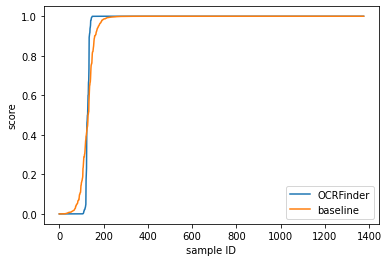

0.9069767441860465


/share/home/jiayren/.conda/envs/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/share/home/jiayren/.conda/envs/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


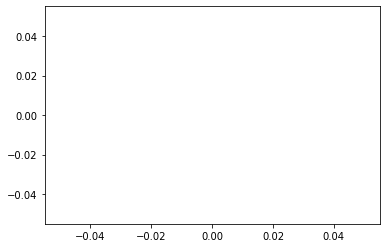

In [4]:
from sklearn.metrics import roc_curve, auc
model_a = load_model('../model/model_a_hema27_150.h5', compile=False)
model_b = load_model('../model/model_b_hema27_150.h5', compile=False)
re_a = model_a([cnn_total_test,lstm_total_test]).numpy()
re_b = model_b([cnn_total_test,lstm_total_test]).numpy()
re = (re_a + re_b) / 2
re.sort(axis=0)
plt.plot(np.arange(0,len(re),1),re, label='OCRFinder')
# plt.show()
count = 0
for rr in re:
    if rr >=0.5:
        count += 1
print(count/len(re))

# fpr,tpr, thresholds = roc_curve(np.ones_like(re),re)
# roc_auc = auc(fpr, tpr)
# plt.plot(fpr, tpr, label='OCRfinder(area=%.4f)'%roc_auc)
# plt.show()

# # m_a = load_model('../model/m_a_hk27_150.h5', compile=False)
# # m_b = load_model('../model/m_b_hk27_150.h5', compile=False)
# re_a = m_a([cnn_test,lstm_test]).numpy()
# re_b = m_b([cnn_test,lstm_test]).numpy()
# re = (re_a + re_b) / 2
# re.sort(axis=0)
# plt.plot(np.arange(0,len(re),1),re, label='Co-teaching')
# # plt.show()
# count = 0
# for rr in re:
#     if rr >=0.5:
#         count += 1
# print(count/len(re))

base_model = load_model('../model/base_model_hema27_150.h5', compile=False)
re_base = base_model([cnn_test,lstm_test]).numpy()
re_base.sort(axis=0)
plt.plot(np.arange(0,len(re_base),1),re_base, label='baseline')
plt.legend()
plt.xlabel('sample ID')
plt.ylabel('score')
plt.show()
count = 0
for rr in re:
    if rr >=0.5:
        count += 1
print(count/len(re))

fpr,tpr, thresholds = roc_curve(np.ones_like(re),re)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='OCRFinder(area=%.4f)'%roc_auc)
fpr,tpr, thresholds = roc_curve(np.ones_like(re_base),re_base)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='baseline(area=%.4f)'%roc_auc)
plt.show()